# Mushroom Classification Using Machine Learning Models

## 1. Introduction

In this project, we aim to build predictive models to classify mushrooms as **edible** or **poisonous**.  
We used the **Mushroom Classification dataset** from the UCI Machine Learning Repository, available on Kaggle [here](https://www.kaggle.com/datasets/uciml/mushroom-classification?resource=download).

The dataset contains **8124 instances** with **22 categorical features** describing physical characteristics of mushrooms, such as cap shape, odor, gill size, and spore print color. The target variable is `class`, indicating whether a mushroom is **edible** or **poisonous**.

In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
df = pd.read_csv("mushrooms.csv")

## 2. Exploratory Data Analysis (EDA)
Before modeling, we explored the dataset to understand its structure and content:

- **Data inspection**: All 22 features are categorical, with no missing values.  
- **Class distribution**: The dataset is fairly balanced with 4208 edible and 3916 poisonous mushrooms.  

In [71]:
print(df.info())
print(df.isnull().sum())
print(df['class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

## 3. Data Preprocessing
Since all features are categorical, we converted them into numerical format for modeling:

1. **One-Hot Encoding**: All categorical features were encoded using one-hot encoding. This avoids artificial numeric ordering and allows the Random Forest model to handle categorical features effectively.    


In [72]:
df_encoded = pd.get_dummies(df, drop_first=True)

2. **Feature Removal**: The two most influential feature groups `odor` and `spore-print-color` were removed from the dataset by dropping all corresponding one-hot encoded columns for Random Forest - Drop.

In [73]:
# 1. Identify columns related to odor and spore-print-color
odor_cols = [c for c in df_encoded.columns if c.startswith('odor_')]
spore_cols = [c for c in df_encoded.columns if c.startswith('spore-print-color_')]

# 2. Define columns to drop (EXCLUDING target)
cols_to_drop = odor_cols + spore_cols + ['class_p']

print("Dropping columns:", cols_to_drop)
print("Total columns dropped:", len(cols_to_drop))

# 3. Create new X3 and y3 (so original X,y stay SAFE)
X3 = df_encoded.drop(cols_to_drop, axis=1)
y3 = df_encoded['class_p']

print("Remaining columns:", X3.shape[1])

Dropping columns: ['odor_c', 'odor_f', 'odor_l', 'odor_m', 'odor_n', 'odor_p', 'odor_s', 'odor_y', 'spore-print-color_h', 'spore-print-color_k', 'spore-print-color_n', 'spore-print-color_o', 'spore-print-color_r', 'spore-print-color_u', 'spore-print-color_w', 'spore-print-color_y', 'class_p']
Total columns dropped: 17
Remaining columns: 79


3. **Target variable**: The `class` column was converted to a binary variable: `0 = edible`, `1 = poisonous`.

In [74]:
X = df_encoded.drop('class_p', axis=1)  # class_p = poisonous (dummy variable)
y = df_encoded['class_p']

In [75]:
X3 = df_encoded.drop(cols_to_drop, axis=1)
y3 = df_encoded['class_p']

## 4. Train-Test Split
The dataset for Decision Tree and Random Forest (Full) was split into training and test sets:

- **Training set**: 80% of the data  
- **Test set**: 20% of the data  
- **Stratification**: Ensures equal proportions of edible and poisonous mushrooms in both sets.  
- **Random state**: Fixed for reproducibility.

While for the Random Forest (Drop):
- **Training set**: 60% of the data  
- **Test set**: 40% of the data  

In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [77]:
X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.4, stratify=y3, random_state=42
)

## 5. Modeling
### Decision Tree
We used a **Decision Tree Classifier** because it can:

- Naturally handle categorical data  
- Learn clear and interpretable if-else rules
- Capture complex, non-linear relationships between features
- Produce interpretable structures

**Model parameters:**

- `criterion = "gini"`  
- `max_depth = 6`    
- `min_samples_split=10`
- `min_samples_leaf=4`
- `max_features=None`
- `random_state = 42`

The model was trained on the training set and evaluated on the test set.

In [78]:
dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features=None,
    random_state=42
)

dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### Random Forest - Full
We used a **Random Forest Classifier** because it can:

- Handle high-dimensional, categorical data  
- Capture nonlinear feature interactions  
- Provide feature importance measures and importance features ranking

**Model parameters:**

- `n_estimators = 300` 
- `max_depth=6`
- `min_samples_split=10`
- `min_samples_leaf=4`
- `max_features = "sqrt"`  
- `random_state = 42`  
- `n_jobs = -1`  

The model was trained on the training set and evaluated on the test set.

In [79]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,6
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Random Forest - Drop
We used a **Random Forest Classifier** with dropping features to test its robustness.

**Model parameters:**

- `n_estimators = 300` 
- `max_depth=6`
- `min_samples_split=10`
- `min_samples_leaf=4`
- `max_features = "sqrt"`  
- `random_state = 42`  
- `n_jobs = -1`  

The model was trained on the training set and evaluated on the test set.

In [80]:
rf3 = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rf3.fit(X3_train, y3_train)

,n_estimators,300
,criterion,'gini'
,max_depth,6
,min_samples_split,10
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 6. Models Evaluation
Evaluation metrics for Decision Tree:
- **Accuracy**: 99.7% on the test set
- **Classification report**: Recall and F1-score were all 1.0 for both classes, but precision was 0.99 for the True class.
- **Confusion matrix**: only 4 FP

Evaluation metrics for Random Forest (Full):
- **Accuracy**: 99.5% on the test set  
- **Classification report**: Precision, recall and F1-score were all between 0.99 and 1.0 for both classes  
- **Confusion matrix**: only 8 FN

Evaluation metrics for Random Forest (Drop):
- **Accuracy**: 98.46% on the test set  
- **Classification report**: Precision, recall and F1-score were all between 0.97 and 1.0 for both classes  
- **Confusion matrix**: 8 FP and 42 FN

Accuracy for Decision Tree: 0.9975384615384615

Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00       842
        True       0.99      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



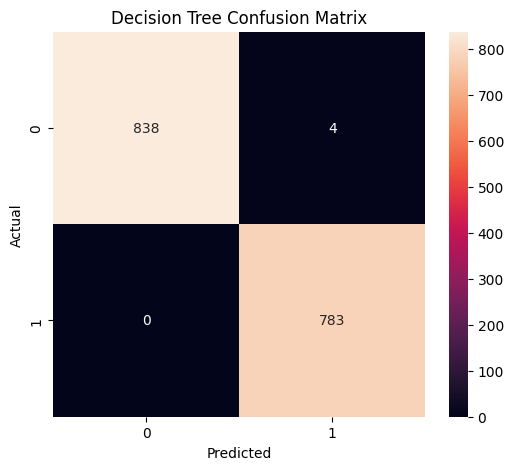

Accuracy for Random Forest (Full): 0.9950769230769231

Classification Report:
               precision    recall  f1-score   support

       False       0.99      1.00      1.00       842
        True       1.00      0.99      0.99       783

    accuracy                           1.00      1625
   macro avg       1.00      0.99      1.00      1625
weighted avg       1.00      1.00      1.00      1625



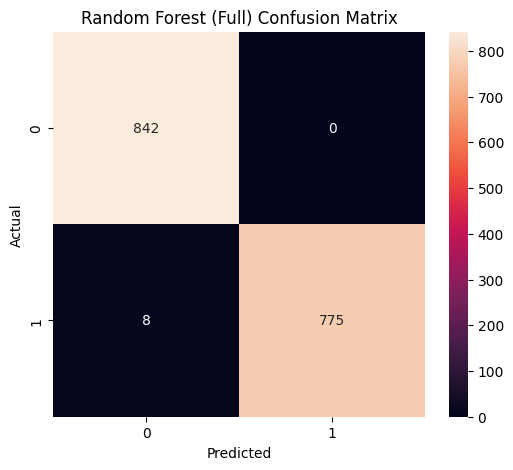

Accuracy for Random Forest (Drop): 0.9846153846153847

Classification Report:
               precision    recall  f1-score   support

       False       0.98      1.00      0.99      1683
        True       0.99      0.97      0.98      1567

    accuracy                           0.98      3250
   macro avg       0.99      0.98      0.98      3250
weighted avg       0.98      0.98      0.98      3250



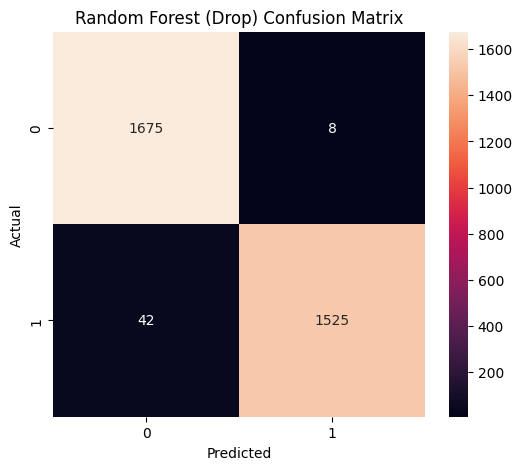

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = dt.predict(X_test)
y_pred2 = rf.predict(X_test)

print("Accuracy for Decision Tree:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Accuracy for Random Forest (Full):", accuracy_score(y_test, y_pred2))
print("\nClassification Report:\n", classification_report(y_test, y_pred2))


plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, fmt='d')
plt.title("Random Forest (Full) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


y3_pred = rf3.predict(X3_test)

print("Accuracy for Random Forest (Drop):", accuracy_score(y3_test, y3_pred))
print("\nClassification Report:\n", classification_report(y3_test, y3_pred))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y3_test, y3_pred), annot=True, fmt='d')
plt.title("Random Forest (Drop) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### fold Cross-validation with StratifiedKFold produced:
- Mean CV accuracy for Decision Tree ≈ 0.997
- Mean CV accuracy for Random Forest (Full) ≈ 0.995
- Mean CV accuracy for Random Forest (Drop) ≈ 0.980


In [82]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(dt, X, y, cv=skf)

print("5-fold CV scores for Decision Tree:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

cv_scores2 = cross_val_score(rf, X, y, cv=skf)

print("5-fold CV scores for Random Forest (Full):", cv_scores2)
print("Mean CV accuracy:", np.mean(cv_scores2))

cv_scores3 = cross_val_score(rf, X3, y3, cv=skf)

print("5-fold CV scores for Random Forest (Drop):", cv_scores3)
print("Mean CV accuracy:", np.mean(cv_scores3))

5-fold CV scores for Decision Tree: [0.99630769 0.99569231 1.         0.99630769 0.99815271]
Mean CV accuracy: 0.9972920803334595
5-fold CV scores for Random Forest (Full): [0.99815385 0.99323077 0.99753846 0.99138462 0.99692118]
Mean CV accuracy: 0.9954457749147403
5-fold CV scores for Random Forest (Drop): [0.98030769 0.97969231 0.984      0.97784615 0.97906404]
Mean CV accuracy: 0.9801820386510041


### Feature Importance
The most important features Both Decision Tree and Random Forest (Full) included:

- `odor` for both models 
- `stalk_root` for Decision Tree
- `spore_print_color` for Random Forest

While For Random Forest (Drop):
- `stalk_surface_above_ring`
- `ring_type`

These features strongly influence whether a mushroom is classified as edible or poisonous.

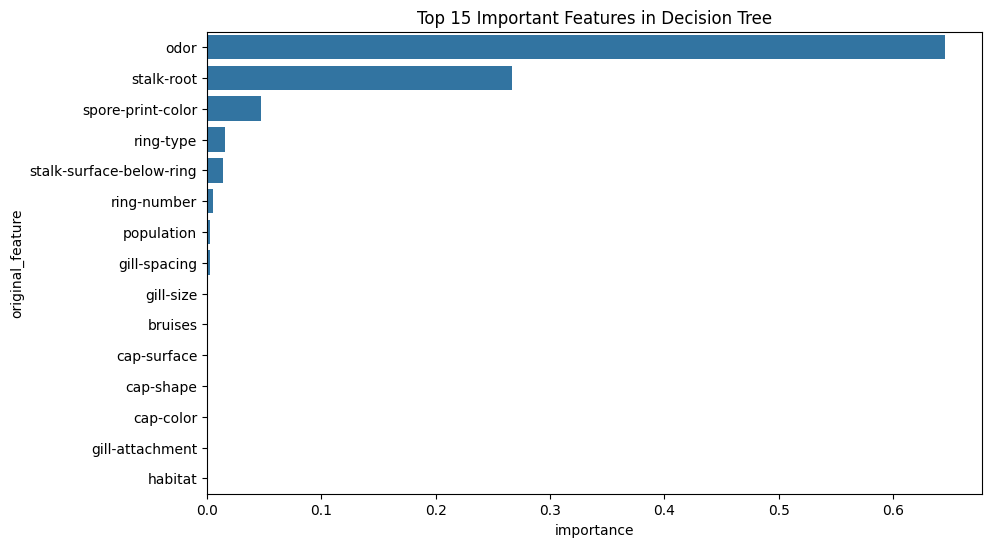

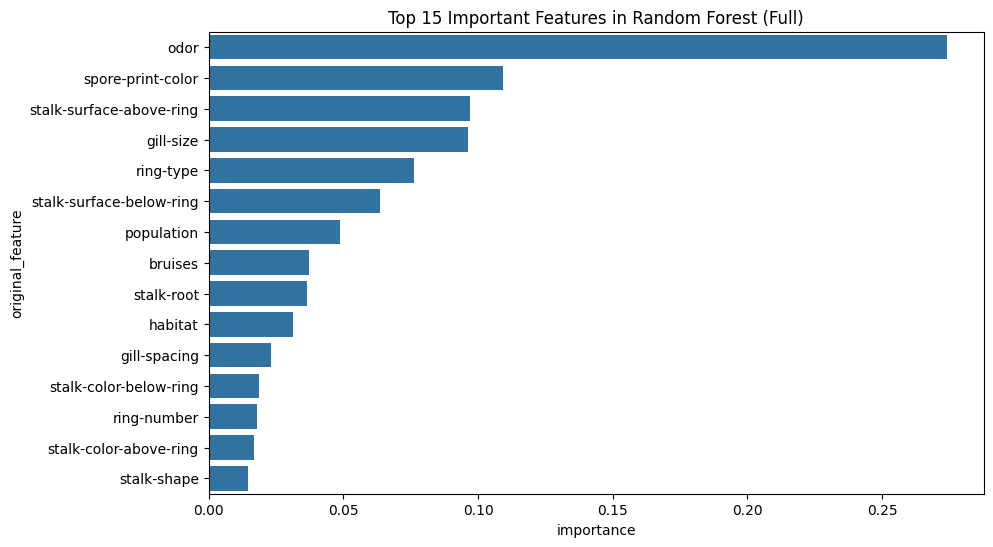

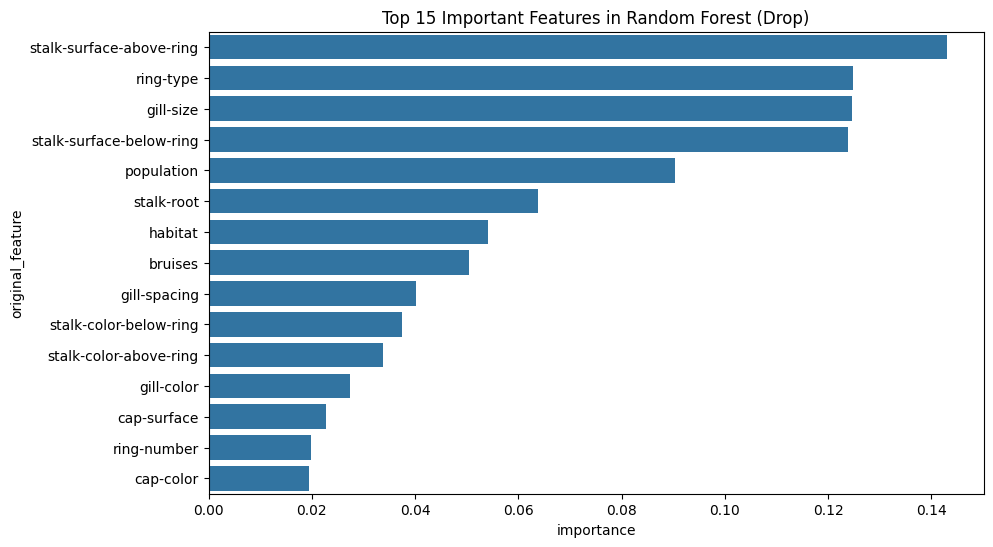

In [83]:
importances = dt.feature_importances_

original_features = [col.split('_')[0] for col in X.columns]
original_features3 = [col.split('_')[0] for col in X3.columns]

importance_df = pd.DataFrame({
    'original_feature': original_features,
    'importance': importances
})

importance_agg = importance_df.groupby('original_feature')['importance'].sum().reset_index()

importance_agg = importance_agg.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='original_feature', x='importance', data=importance_agg.head(15))
plt.title("Top 15 Important Features in Decision Tree")
plt.show()

importances2 = rf.feature_importances_

importance_df2 = pd.DataFrame({
    'original_feature': original_features,
    'importance': importances2
})

importance_agg2 = importance_df2.groupby('original_feature')['importance'].sum().reset_index()

importance_agg2 = importance_agg2.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='original_feature', x='importance', data=importance_agg2.head(15))
plt.title("Top 15 Important Features in Random Forest (Full)")
plt.show()

importances3 = rf3.feature_importances_

importance_df3 = pd.DataFrame({
    'original_feature': original_features3,
    'importance': importances3
})

importance_agg3 = importance_df3.groupby('original_feature')['importance'].sum().reset_index()

importance_agg3 = importance_agg3.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(y='original_feature', x='importance', data=importance_agg3.head(15))
plt.title("Top 15 Important Features in Random Forest (Drop)")
plt.show()

### ROC Curves

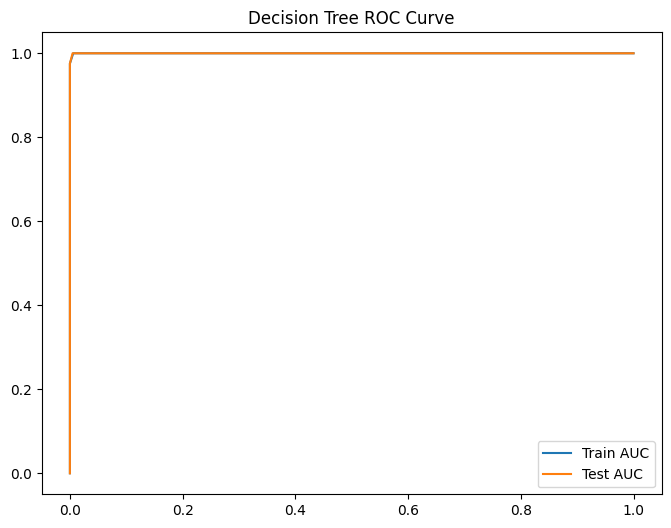

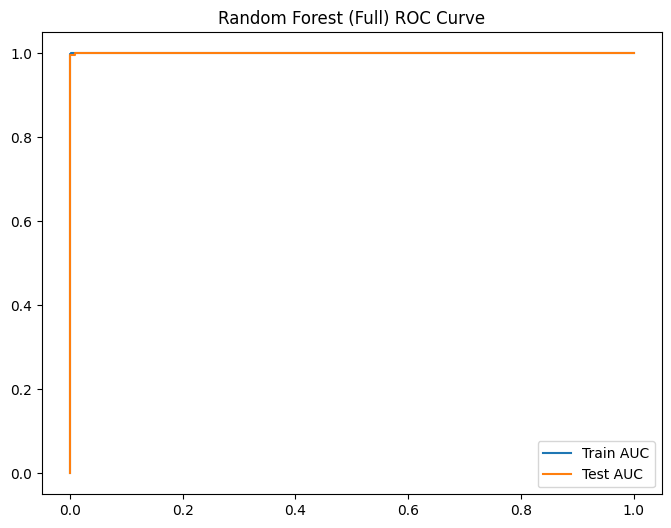

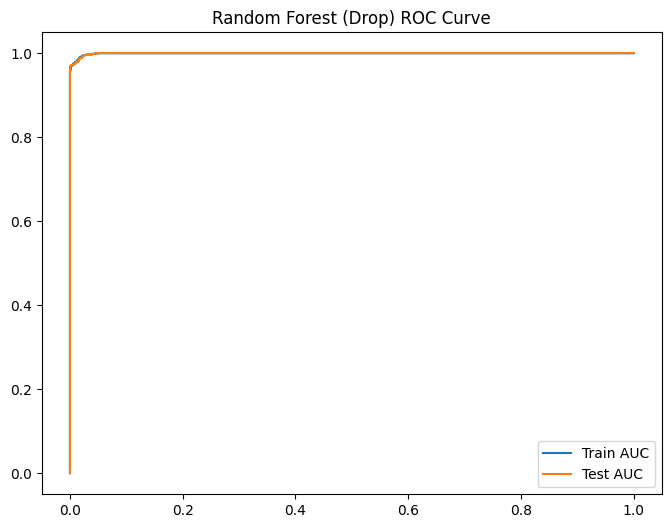

In [84]:
from sklearn.metrics import roc_curve, auc

y_train_prob = dt.predict_proba(X_train)[:,1]
y_test_prob  = dt.predict_proba(X_test)[:,1]

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
fpr_test, tpr_test, _   = roc_curve(y_test, y_test_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, label="Train AUC")
plt.plot(fpr_test, tpr_test, label="Test AUC")
plt.legend()
plt.title("Decision Tree ROC Curve")
plt.show()

y_train_prob2 = rf.predict_proba(X_train)[:,1]
y_test_prob2  = rf.predict_proba(X_test)[:,1]

fpr_train2, tpr_train2, _ = roc_curve(y_train, y_train_prob2)
fpr_test2, tpr_test2, _   = roc_curve(y_test, y_test_prob2)

plt.figure(figsize=(8,6))
plt.plot(fpr_train2, tpr_train2, label="Train AUC")
plt.plot(fpr_test2, tpr_test2, label="Test AUC")
plt.legend()
plt.title("Random Forest (Full) ROC Curve")
plt.show()

y3_train_prob = rf3.predict_proba(X3_train)[:,1]
y3_test_prob  = rf3.predict_proba(X3_test)[:,1]

fpr3_train, tpr3_train, _ = roc_curve(y3_train, y3_train_prob)
fpr3_test,  tpr3_test,  _ = roc_curve(y3_test,  y3_test_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr3_train, tpr3_train, label="Train AUC")
plt.plot(fpr3_test,  tpr3_test,  label="Test AUC")
plt.legend()
plt.title("Random Forest (Drop) ROC Curve")
plt.show()
